In [ ]:
!pip install pyvi
!pip install plotly
!pip install gensim
!pip install pyLDAvis
!pip3 install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.7 MB/s eta 0:00:00


In [ ]:
#Kết nối với GG Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
from IPython.utils import io

# Suppress warnings
with io.capture_output() as captured:
    warnings.filterwarnings("ignore")


In [ ]:
# import visulizatoin using Plotly library
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots

# For data visualization
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

# To view the most frequent words
from wordcloud import WordCloud

# Timer to track the run time or completeion of execution
from tqdm import tqdm

# Data Manipulation
import pandas as pd
import numpy as np

# To use regular expression
import re

# To find frequency of a token occuring in corpus
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Used different type of containers to store collection
from collections import Counter, defaultdict
import itertools
import collections

# use algo related to NLP
import nltk
from nltk import bigrams
from nltk import ngrams
from nltk.corpus import stopwords

# Lematization
import spacy

# To visualize data in graph format
import networkx as nx

# Decode emoji's into text
!pip install demoji
import demoji

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import numpy as np # linear algebra
import pandas as pd # data processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Load Vietnamese stopwords from the file
with open("/content/drive/MyDrive/Hotel_sentiment/data/vietnamese-stopwords.txt", "r", encoding="utf-8") as f:
    vietnamese_stopwords = set(f.read().splitlines())

# Load the Excel file
df = pd.read_excel(r"/content/drive/MyDrive/Hotel_sentiment/data/Dataset_Tripadvisor.xlsx")


In [ ]:
df.shape

(5334, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    5334 non-null   object 
 1   rating   5333 non-null   float64
 2   content  5333 non-null   object 
 3   Hotel    5333 non-null   object 
dtypes: float64(1), object(3)
memory usage: 166.8+ KB


In [ ]:
df.isna().sum()

,0
title,0
rating,1
content,1
Hotel,1


*No* Missing values in the dataset.

In [ ]:
df['rating'].value_counts(normalize = True)*100

rating
5.0    86.555410
4.0     5.400338
3.0     4.612788
1.0     2.006375
2.0     1.425089
Name: proportion, dtype: float64


*   Positive Reviews: Around 91.96% of the reviews given by customers are positive (ratings 4.0 and 5.0 combined).


*   Neutral Reviews: Approximately 4.61% of the reviews are neutral (rating 3.0).


*   Negative Reviews: Almost 3.43% of the reviews are negative (ratings 1.0 and 2.0 combined).





## Processing Data

In [ ]:
import unicodedata
import regex as re
from pyvi import ViTokenizer
import pandas as pd

bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

def chuan_hoa_unicode(text):
    text = unicodedata.normalize('NFC', str(text))  # Ensure text is converted to string
    return text

def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars): # xử lí từng kí tự trong từ
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        #Xử lý các trường hợp đặc biệt "qu" và "gi"
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)

def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

def chuan_hoa_dau_cau_tieng_viet(sentence):
    if isinstance(sentence, str):
        sentence = sentence.lower()
        words = sentence.split()
        for index, word in enumerate(words):
            cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
            if len(cw) == 3:
                cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
            words[index] = ''.join(cw)
        return ' '.join(words)
    else:
        return ''

def tach_tu_tieng_viet(text):
    text = ViTokenizer.tokenize(text)
    return text

def chuyen_chu_thuong(text):
    return text.lower()

def chuan_hoa_cau(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tien_xu_li(text):
    text = chuan_hoa_unicode(text)
    text = chuan_hoa_dau_cau_tieng_viet(text)
    text = tach_tu_tieng_viet(text)
    text = chuyen_chu_thuong(text)
    text = chuan_hoa_cau(text)
    return text

def loai_bo_stopword(text):
    words = text.split()
    filtered_words = [word for word in words if word not in vietnamese_stopwords]
    return ' '.join(filtered_words)

def chu_thuong_vietnamese(text):
    return text.lower()

# Emoji handling function
def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string

# Assuming df is defined
tqdm.pandas()

# Download emoji codes
demoji.download_codes()

In [ ]:
# Convert all text data to string format
df['content'] = df['content'].astype(str)
df['title'] = df['title'].astype(str)

# Tokenize the content and show tokenized examples
# Preprocess the 'content' and 'title' columns
df['title'] = df['title'].apply(tien_xu_li)
df['content'] = df['content'].apply(tien_xu_li)

# Apply the new functions to preprocess the 'content' and 'title' columns
df['title'] = df['title'].apply(loai_bo_stopword)
df['title'] = df['title'].apply(chu_thuong_vietnamese)
df['content'] = df['content'].apply(loai_bo_stopword)
df['content'] = df['content'].apply(chu_thuong_vietnamese)

print(df)


                                                  title  rating  \
0                                       meeting smollan     5.0   
1                                        terumo meeting     5.0   
2                                               lưu_trú     5.0   
3                                 8th anni cty phú_quốc     5.0   
4                                           ptg meeting     5.0   
...                                                 ...     ...   
5329                            một_số lưu_ý hoàn_thiện     3.0   
5330  cảm_thấy lừa_dối bộ_phận lễ_tân cskh xử_lý vấn...     1.0   
5331                                           view đẹp     3.0   
5332                                   mercure vũng_tàu     3.0   
5333     thực_sự thất_vọng chất_lượng phục_vụ khách_sạn     3.0   

                                                content  \
0     thái_độ phục_vụ nhân_viên nhiệt_tình chu_đáo h...   
1     phòng họp view đẹp mát nhân_viên phục_vụ hỗ_tr...   
2     dc nâng_cấp 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


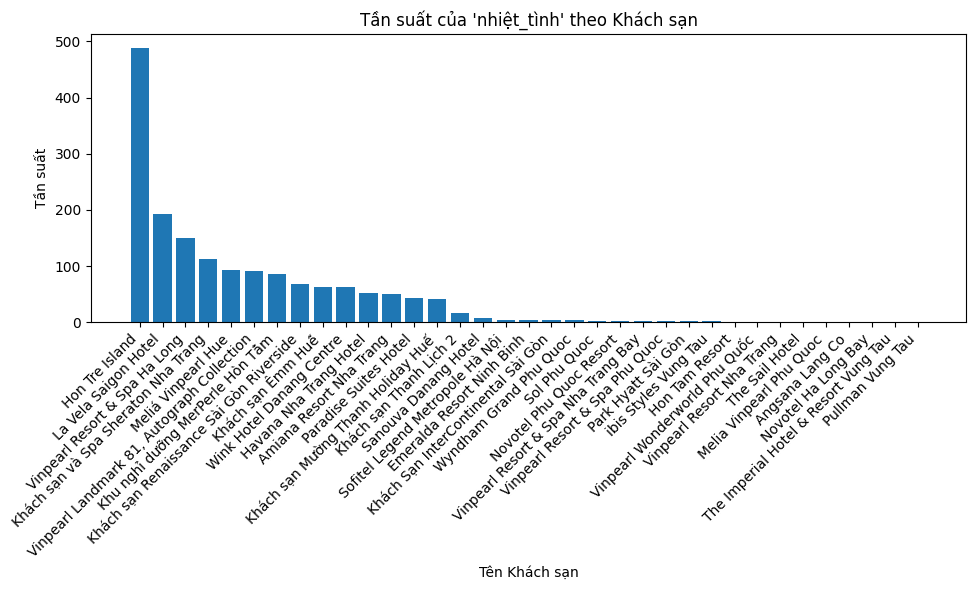

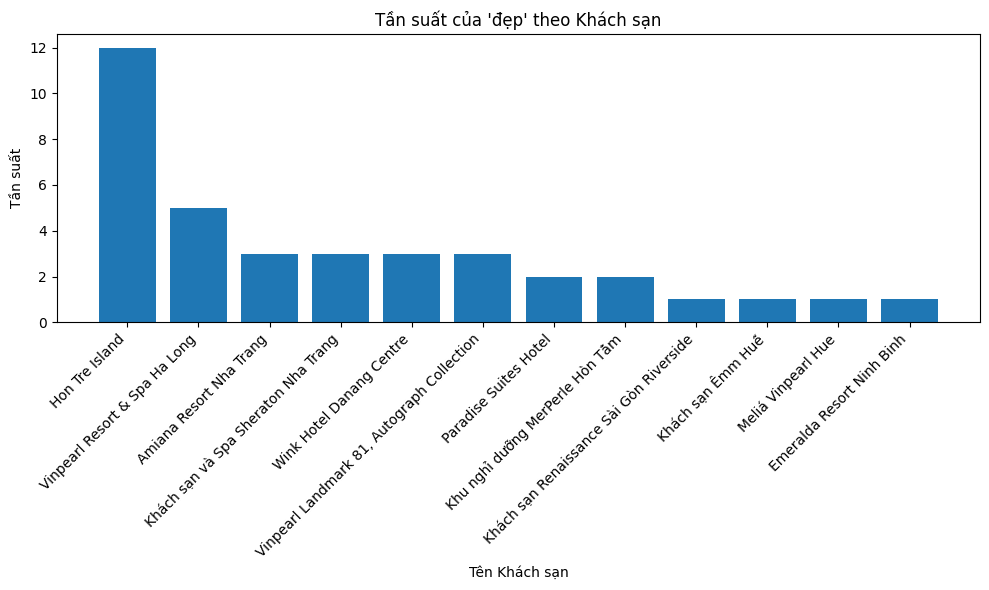

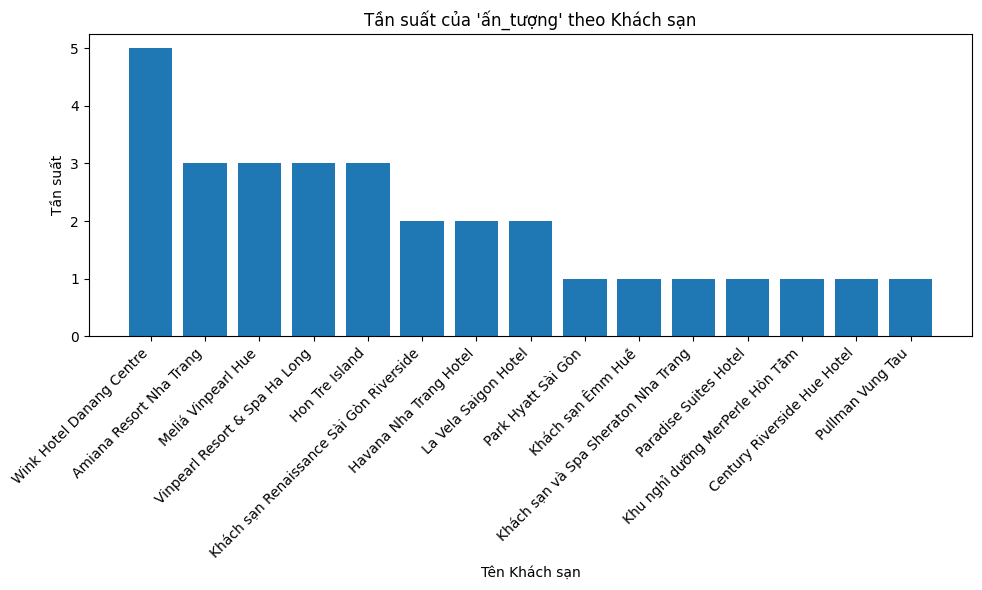

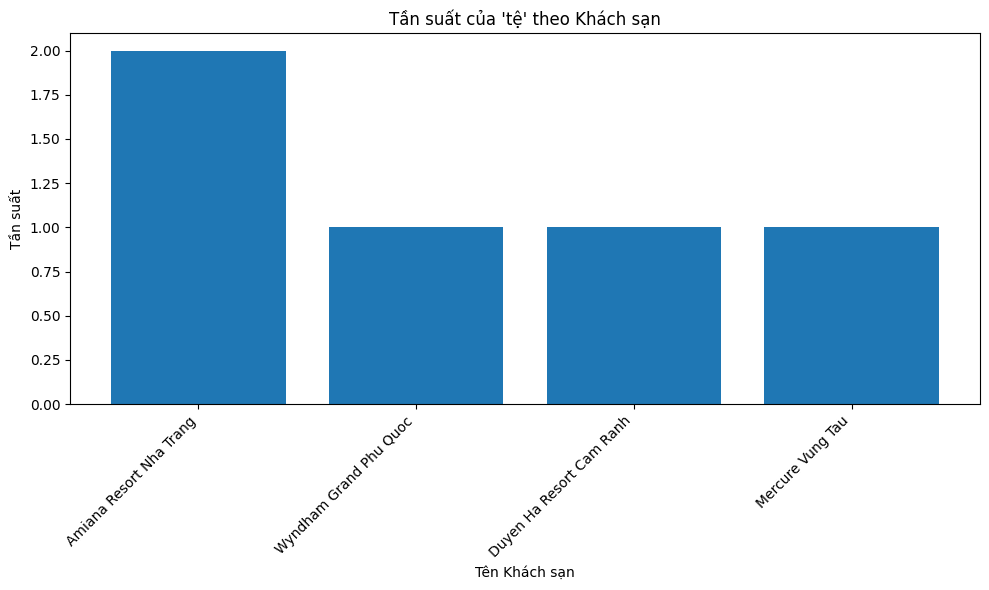

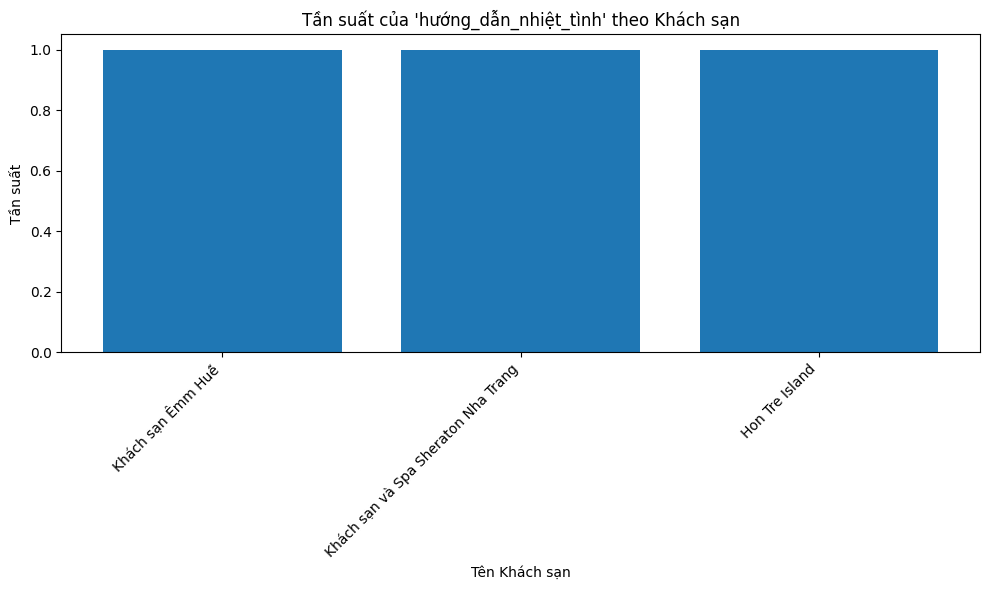

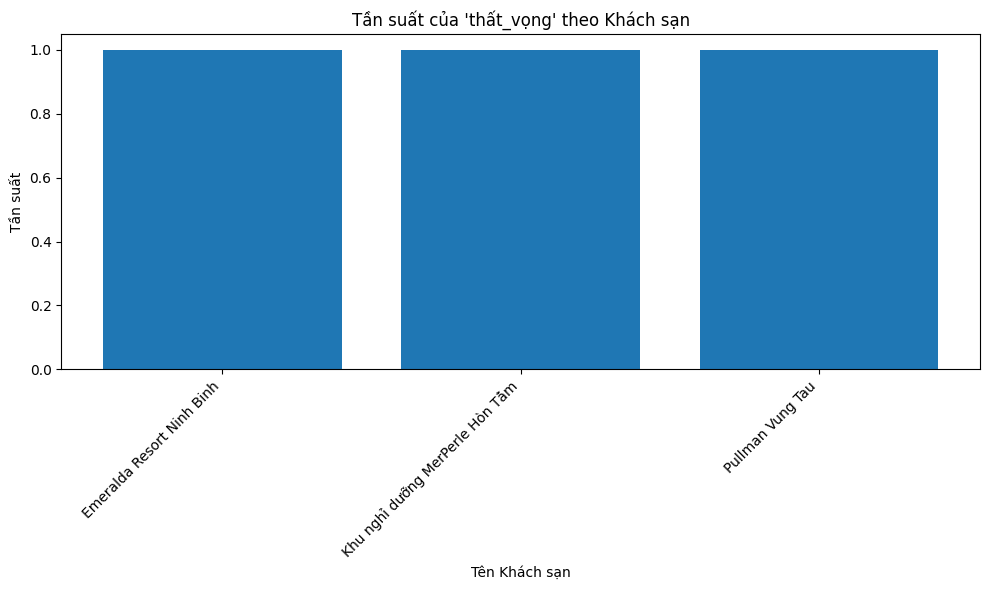

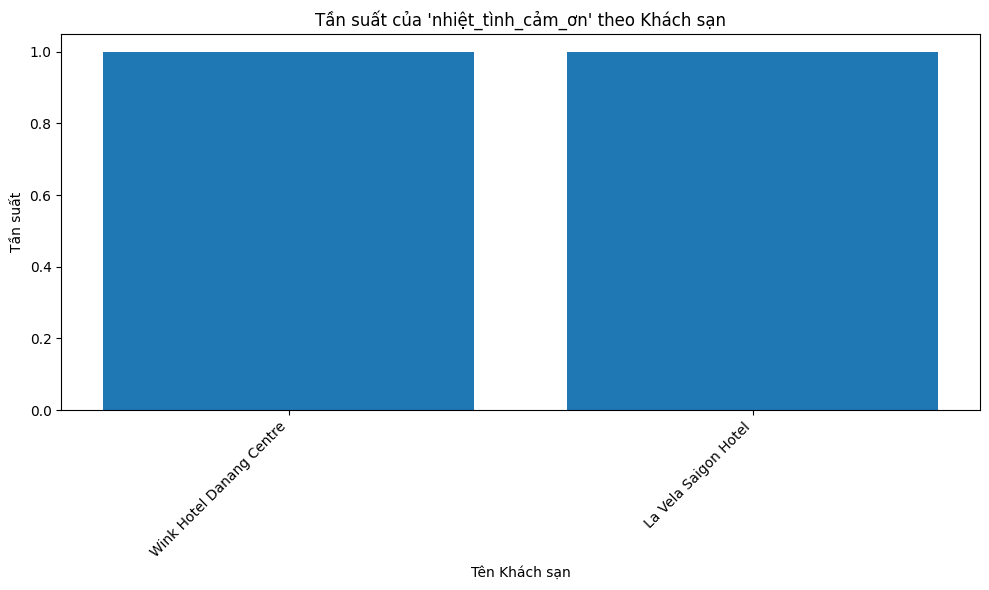

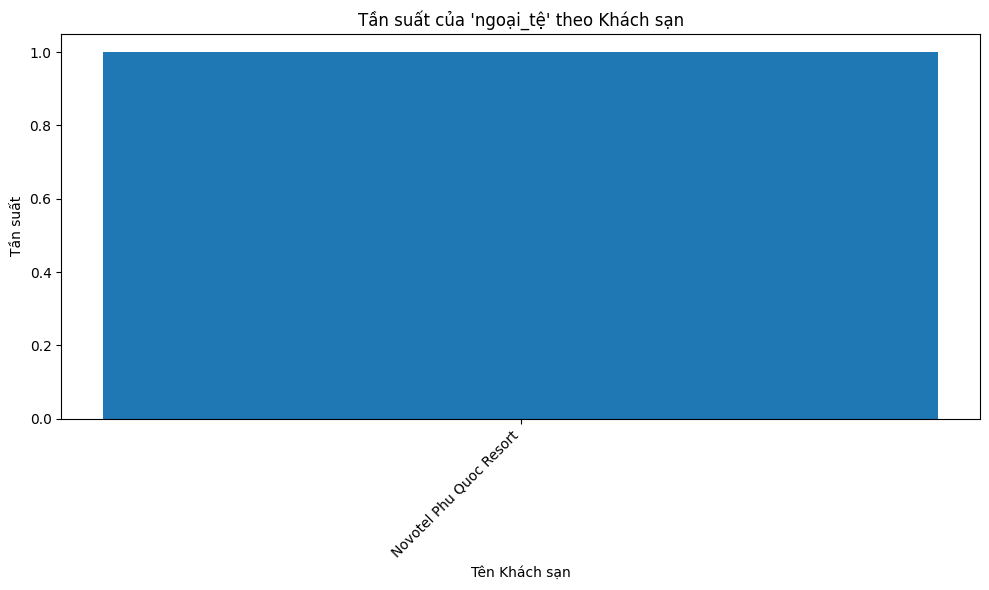

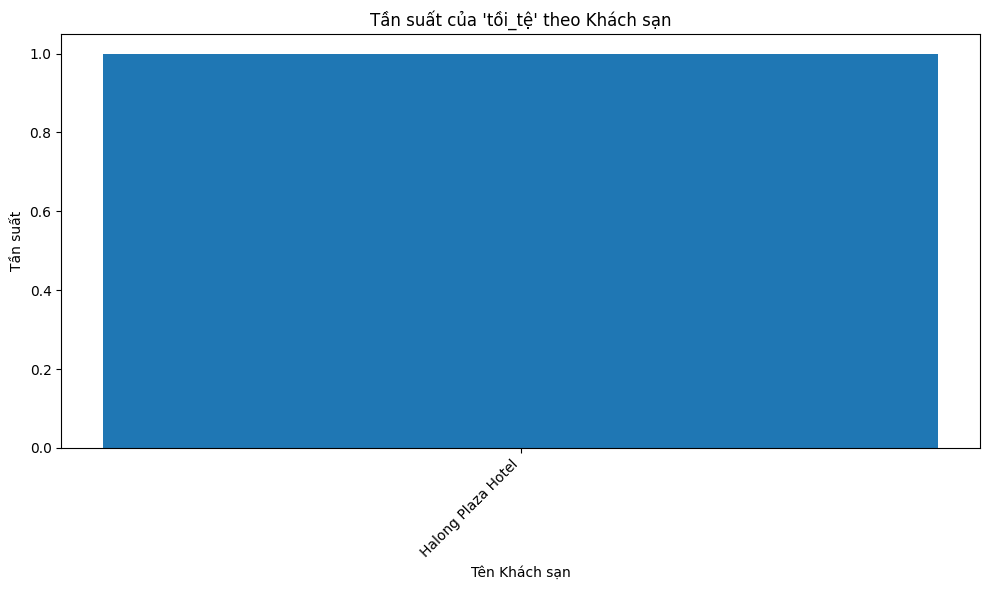

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk

# Tải xuống các tài nguyên cần thiết cho NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Hàm lọc ra các tính từ đánh giá từ văn bản
def filter_evaluative_adjectives(text):
    tokens = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(tokens)
    evaluative_adj = [word for word, pos in tagged_words if pos.startswith('JJ') 
                      and any(evaluative_word in word.lower() for evaluative_word 
                              in ["tốt", "thất_vọng", "đẹp", "tệ", "xấu", "khó_chịu", 
                                  "tồi_tệ", "ấn_tượng", "nhiệt_tình"])]
    return evaluative_adj

# Áp dụng hàm filter_evaluative_adjectives lên cột 'content' và kết hợp tất cả các tính từ vào một danh sách
evaluative_adjectives_list = [adj for content in df['content']
                              for adj in filter_evaluative_adjectives(content)]

# Đếm tần suất của từng tính từ đánh giá
evaluative_adjectives_freq = Counter(evaluative_adjectives_list)

# Chọn ra 10 tính từ đánh giá phổ biến nhất
top_10_evaluative_adjectives = evaluative_adjectives_freq.most_common(10)

# Vẽ biểu đồ tần suất của từng tính từ đánh giá theo khách sạn
for adjective, _ in top_10_evaluative_adjectives:
    adjective_df = df[df['content'].apply(lambda x: adjective 
                                          in filter_evaluative_adjectives(x))]
    hotel_counts = adjective_df['Hotel'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.bar(hotel_counts.index, hotel_counts.values)
    plt.title(f"Tần suất của '{adjective}' theo Khách sạn")
    plt.xlabel("Tên Khách sạn")
    plt.ylabel("Tần suất")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## Most repeated word have shown using Word Cloud here

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py

# Calculate word frequencies
all_words = df['content'].str.split(expand=True).unstack().value_counts()

# Create a bar chart
data = [
    go.Bar(
        x=all_words.index[:50],
        y=all_words.values[:50],
        marker=dict(colorscale='Jet', color=all_words.values[:50]),
        text='Word counts'
    )
]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word Frequencies in the Training Dataset',
    xaxis=dict(title='Words'),
    yaxis=dict(title='Frequency')
)

fig = go.Figure(data=data, layout=layout)

# Plot the chart
py.plot(fig, filename='basic-bar.html')


'basic-bar.html'

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

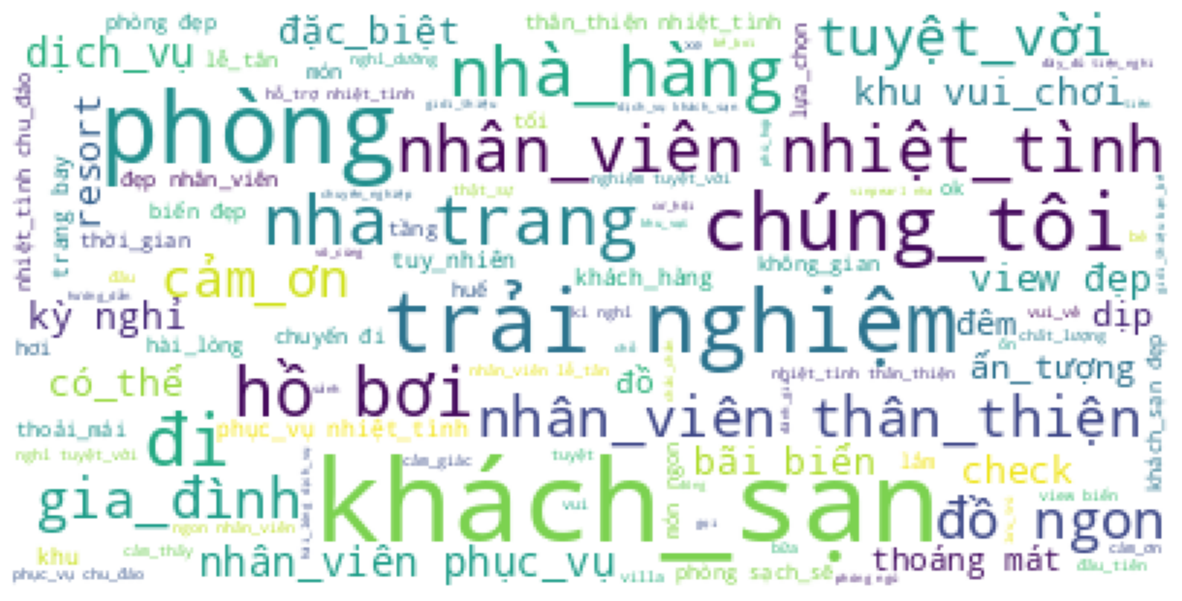

In [ ]:
# Convert float values to strings
df['content'] = df['content'].astype(str)

# Show word cloud
show_wordcloud(df["content"].values)


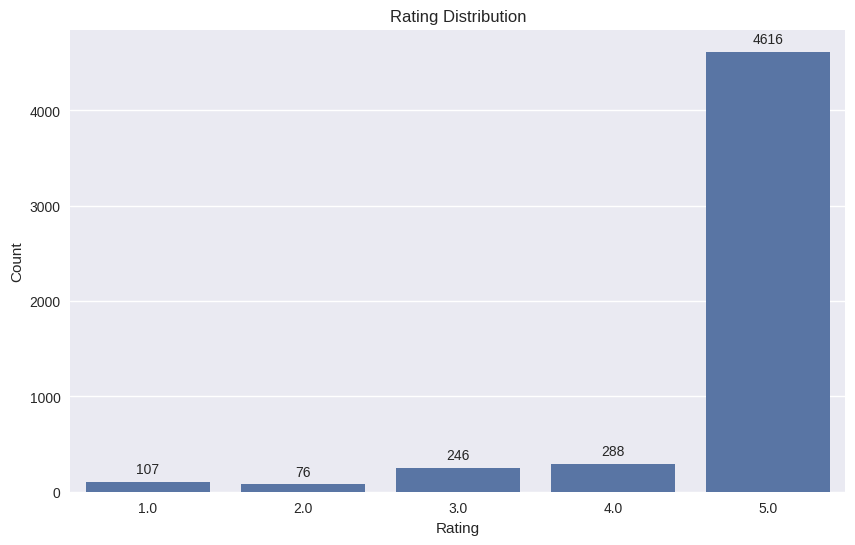

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

# Bar plot
ax = sns.countplot(data=df, x='rating')

# Annotate count values on the bar plot
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()


##Plot the distribution of a feature in the data


In [ ]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2

# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

In [ ]:
# encode label and mapping label name
df["label"] = df["rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))
print(df.head(10))

                   title  rating  \
0        meeting smollan     5.0   
1         terumo meeting     5.0   
2                lưu_trú     5.0   
3  8th anni cty phú_quốc     5.0   
4            ptg meeting     5.0   
5                meeting     5.0   
6             good staff     5.0   
7       đánh_giá phục_vụ     5.0   
8    rbar at renaissance     5.0   
9                 tạm ổn     3.0   

                                             content  \
0  thái_độ phục_vụ nhân_viên nhiệt_tình chu_đáo h...   
1  phòng họp view đẹp mát nhân_viên phục_vụ hỗ_tr...   
2  dc nâng_cấp phòng hướng sông view phòng tuyệt_...   
3  team banquet nhiêt tình phối_hợp team events c...   
4  nhân_viên khách_sạn hỗ_trợ nhiệt_tình phuc vụ ...   
5  họp diễn khách_sạn renaissance reverside ấn_tư...   
6  món nhẹ họp ngon trang_trí đẹp phòng họp thoán...   
7  phục_vụ nhân_viên dễ_thương đồ ngon phong_phú ...   
8  tuần renaissace uống ngon nhân_viên nhi phương...   
9  đồ uống tạm bánh hơi dâu_tây tươi lobby 

In [ ]:
# calculate char count for each review
df['char_count'] = df['content'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

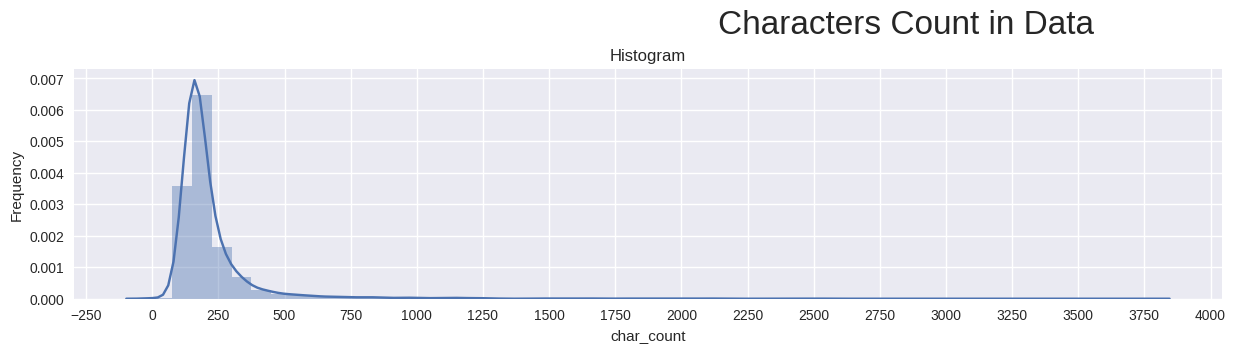

In [ ]:
plot_dist3(df, 'char_count', 'Characters Count in Data')

In [ ]:
# Creating a new feature for the visualization.
df['Character Count'] = df['content'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

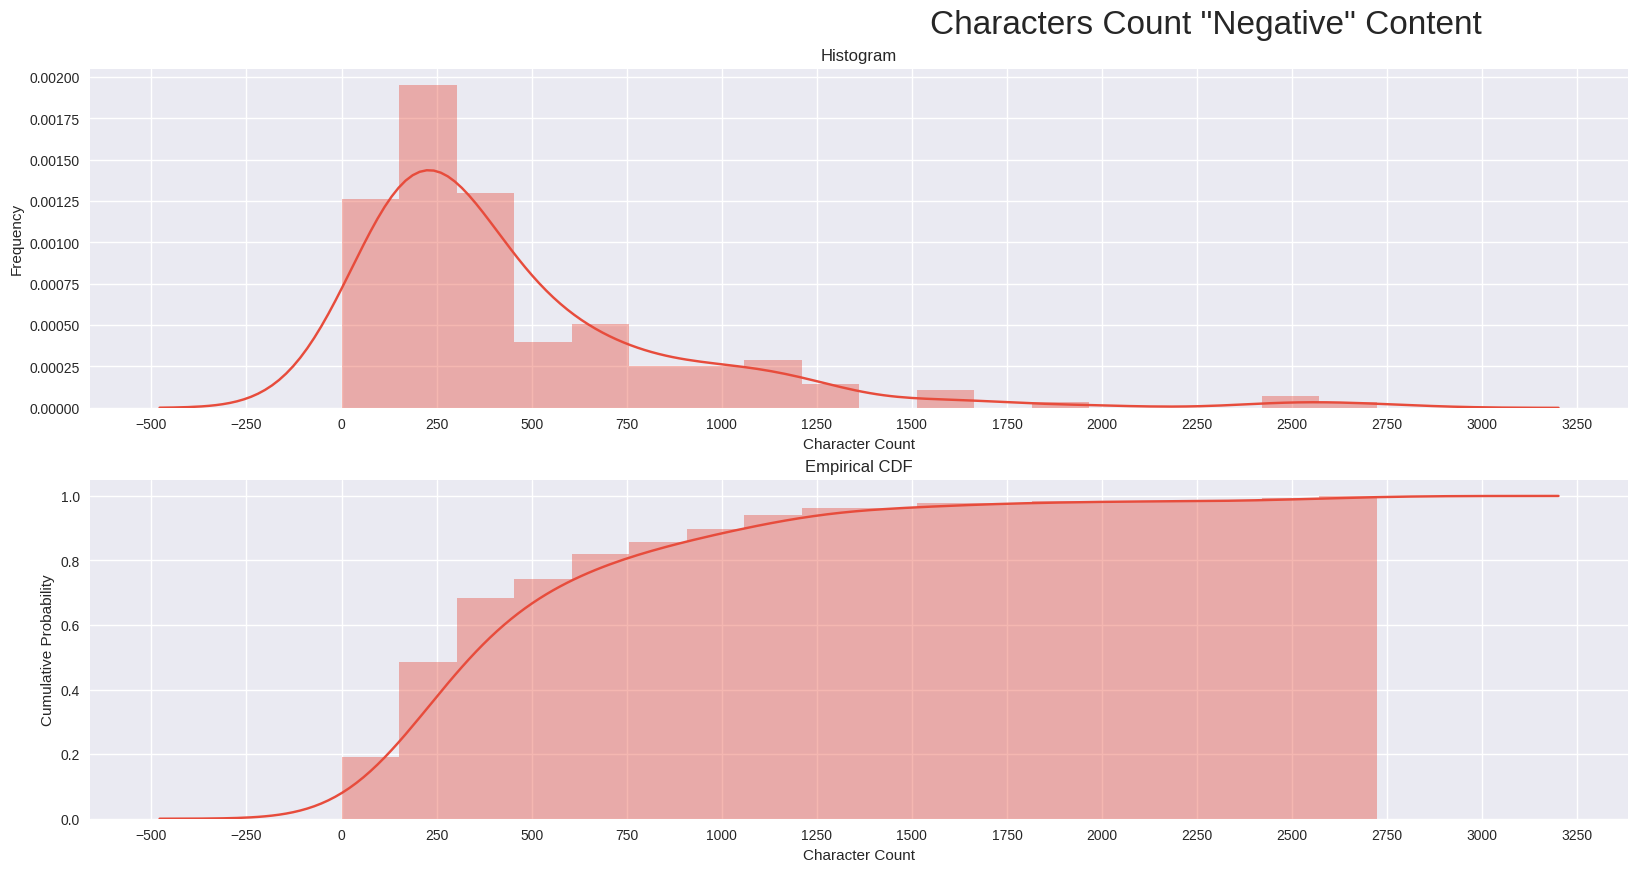

In [ ]:
plot_dist3(df[df['label'] == 0], 'Character Count', 'Characters Count "Negative" Content')

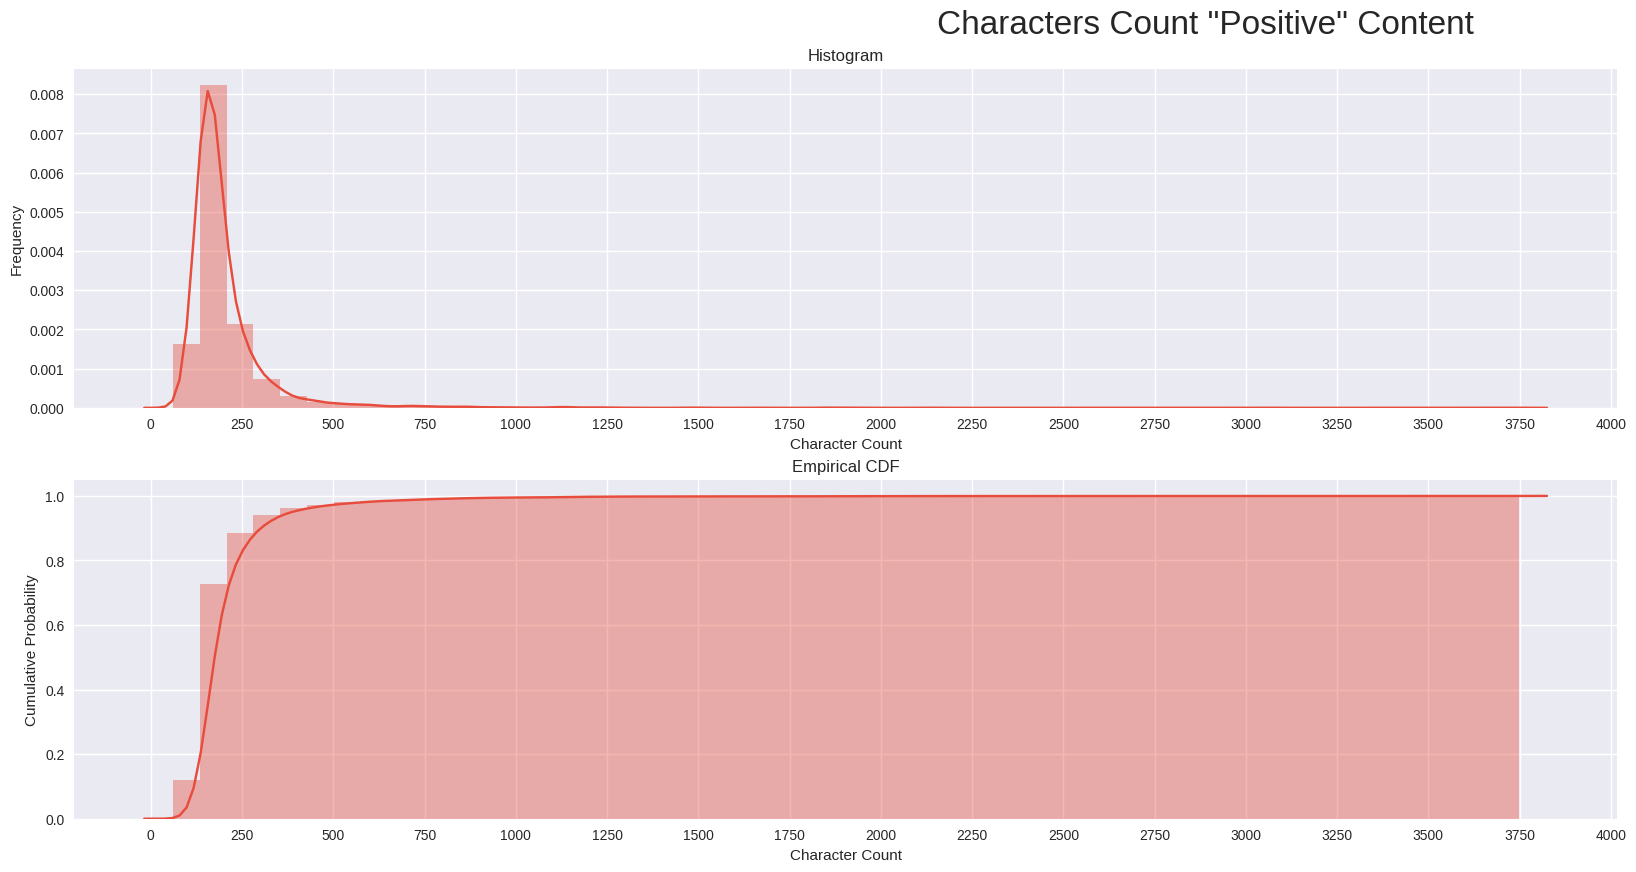

In [ ]:
plot_dist3(df[df['label'] == 2], 'Character Count', 'Characters Count "Positive" Content')

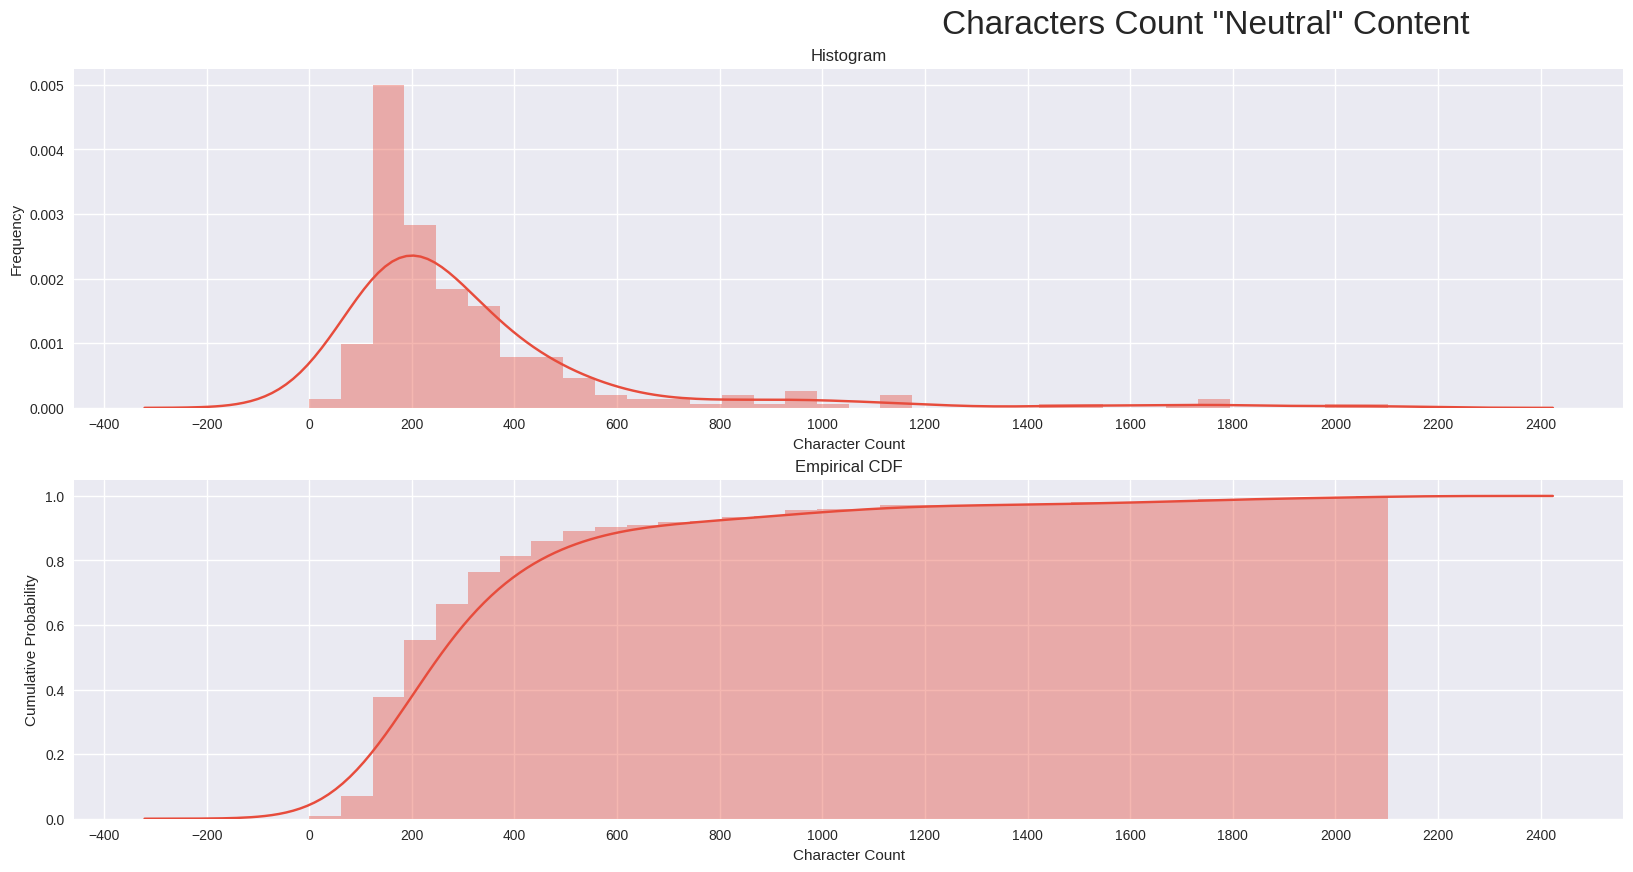

In [ ]:
plot_dist3(df[df['label'] == 1], 'Character Count', 'Characters Count "Neutral" Content')